###### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/cmamega_example.ipynb)

# Optimizing with CMA-ME in Jax

This notebook shows how to use QDax to find diverse and performing parameters on Rastrigin or Sphere problem with [CMA-ME](https://arxiv.org/pdf/1912.02400.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ME emitter
- how to create a MAP-Elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [1]:
import math

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex
    
try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_opt_emitter import CMAOptimizingEmitter
from qdax.core.emitters.cma_rnd_emitter import CMARndEmitter
from qdax.core.emitters.cma_improvement_emitter import CMAImprovementEmitter
from qdax.core.emitters.cma_pool_emitter import CMAPoolEmitter
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire

from qdax.core.emitters.evosax_cma_me import (
    EvosaxCMAImprovementEmitter,
    EvosaxCMAOptimizingEmitter,
    EvosaxCMARndEmitter,
) 

from typing import Dict

/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please u

## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [2]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 10000 #70000 #10000
num_dimensions = 10 #1000 #@param {type:"integer"}
grid_shape = (100, 100) # (500, 500) 
batch_size = 100 #36 #@param {type:"integer"}
sigma_g = .1 #@param {type:"number"}
minval = 0 #@param {type:"number"}
maxval = 1 #@param {type:"number"}
min_bd = 0 #@param {type:"number"}
max_bd = 1 #@param {type:"number"}
emitter_type = "imp" #@param["opt", "imp", "rnd"]
pool_size = 10 #@param {type:"integer"}

es_type = "custom" # QDax CMA-ES implementation
es_type = "CMA_ES"
# es_type = "Sep_CMA_ES"
#@markdown ---

In [3]:
from evosax import Strategies
if es_type != "custom":
    assert es_type in Strategies, f"{es_type} is not one of {Strategies.keys()}"

## Defines the scoring function: arm

In [4]:
import functools

from qdax.tasks.arm import arm_scoring_function as scoring_fn
from qdax.utils.metrics import default_qd_metrics

metrics_fn = functools.partial(
    default_qd_metrics,
    qd_offset=0.0,
)

## Define initial population, emitter and MAP Elites instance

The emitter is defined using the CMAME emitter class. This emitter is given to a MAP-Elites instance to create an instance of the CMA-ME algorithm.

In [5]:
random_key = jax.random.PRNGKey(0)
# in CMA-ME settings (from the paper), there is no init population
# we multipy by zero to reproduce this setting
initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions)) * 0.

centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_bd,
    maxval=max_bd,
)

es_params = {
    "sigma_init": sigma_g,
}

emitter_kwargs = {
    "batch_size": batch_size,
    "genotype_dim": num_dimensions,
    "centroids": centroids,
    "min_count": 1,
    "max_count": None,
    "es_params": es_params,
}

if es_type == "custom":
    if emitter_type == "opt":
        emitter = CMAOptimizingEmitter(**emitter_kwargs)
    elif emitter_type == "imp":
        emitter = CMAImprovementEmitter(**emitter_kwargs)
    elif emitter_type == "rnd":
        emitter = CMARndEmitter(**emitter_kwargs)
    else:
        raise Exception("Invalid emitter type")
else:
    emitter_kwargs["es_type"] = es_type
    if emitter_type == "opt":
        emitter = EvosaxCMAOptimizingEmitter(**emitter_kwargs)
    elif emitter_type == "imp":
        emitter = EvosaxCMAImprovementEmitter(**emitter_kwargs)
    elif emitter_type == "rnd":
        emitter = EvosaxCMARndEmitter(**emitter_kwargs)
    else:
        raise Exception("Invalid emitter type")

emitter = CMAPoolEmitter(
    num_states=pool_size,
    emitter=emitter
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_fn
)

{'sigma_init': 0.1}


In [6]:
emitter

## Init the repertoire and emitter state

In [7]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

/home/paul/Dev/QDax/qdax/core/map_elites.py:80: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


## Run optimization/illumination process

In [8]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

CPU times: user 15.7 s, sys: 3.17 s, total: 18.9 s
Wall time: 18.2 s


In [9]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 1000000: 79.1199951171875
max_fitness after 1000000: -0.0
qd_score after 1000000: -222.54718017578125


## Plot results

Update the savefig variable to save your results locally.

Save figure in:  ./plots/arm_10/EvoSax CMA_ES_ME_imp.png


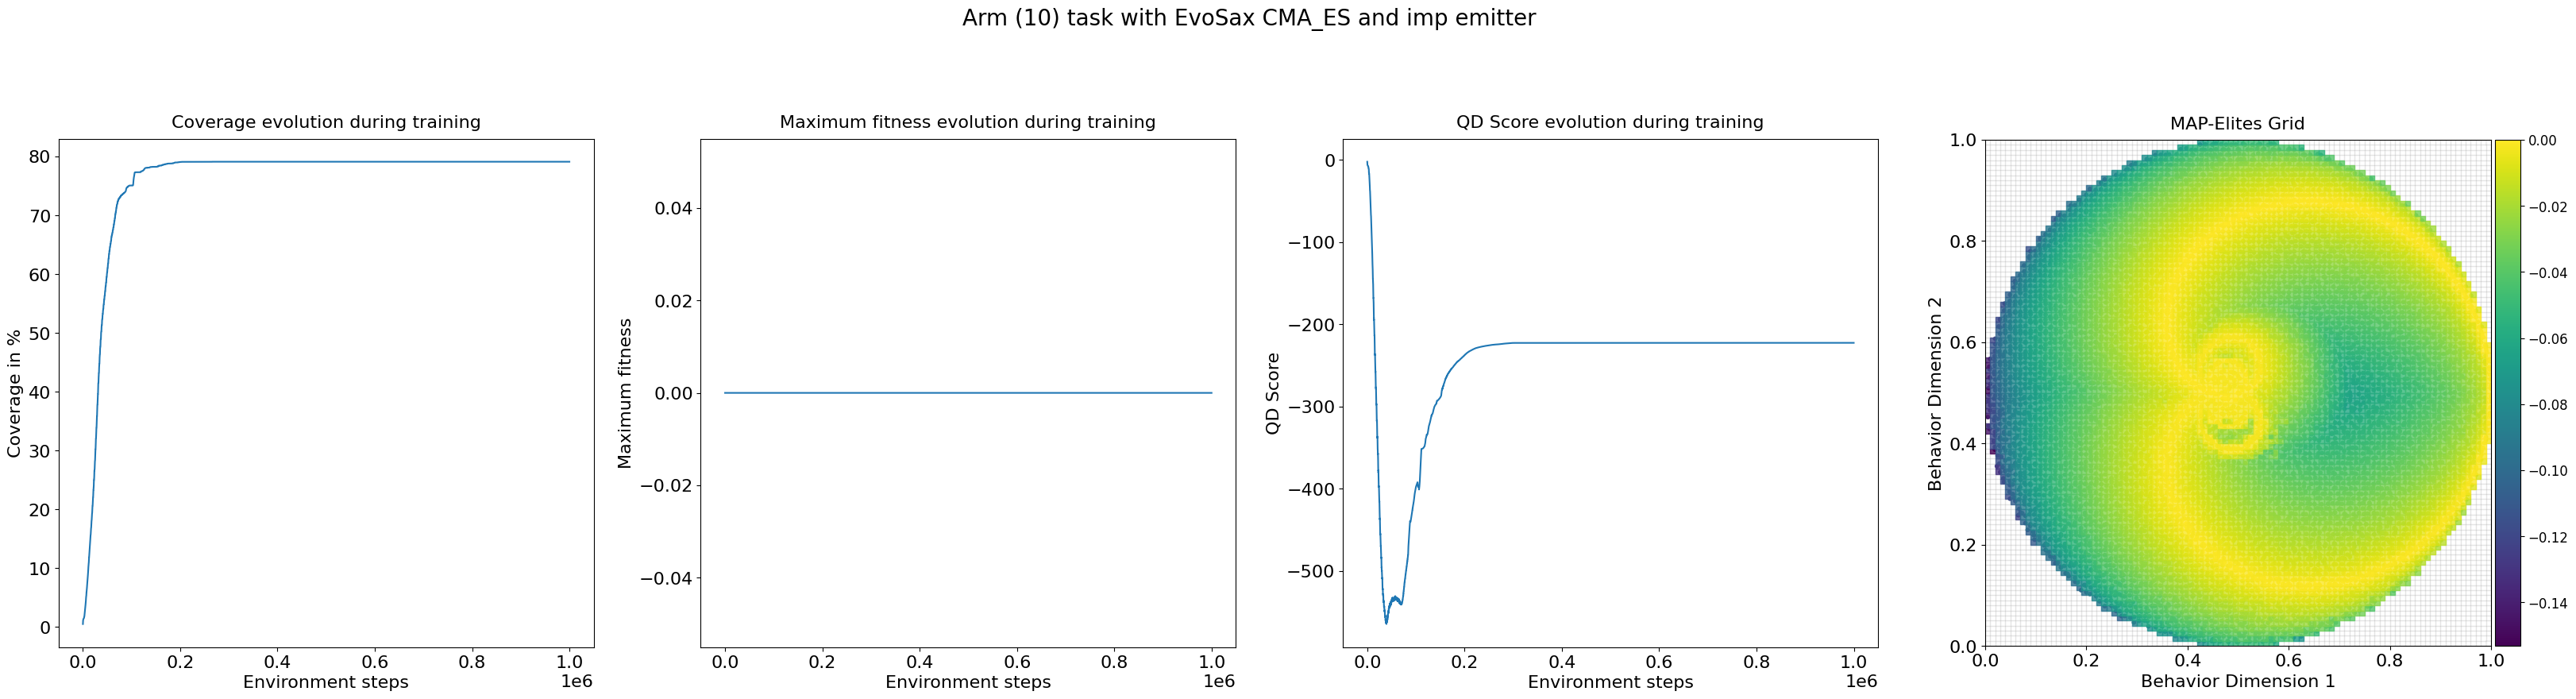

In [10]:
env_steps = jnp.arange(num_iterations) * batch_size

from qdax.utils.plotting import plot_map_elites_results
import matplotlib

%matplotlib inline

fig, axes = plot_map_elites_results(
    env_steps=env_steps,
    metrics=metrics,
    repertoire=repertoire,
    min_bd=min_bd,
    max_bd=max_bd,
)

# main title
if es_type == "custom":
    es_type = "QDax CMA-ES"
else:
    es_type = "EvoSax " + es_type
plt.suptitle(f"Arm ({num_dimensions}) task with {es_type} and {emitter_type} emitter", fontsize=20)

# udpate this variable to save your results locally
savefig = True
if savefig:
    figname = f"./plots/arm_{num_dimensions}/{es_type}_ME_"  + emitter_type + ".png"
    # create folder if it does not exist
    import os
    os.makedirs(os.path.dirname(figname), exist_ok=True)
    print("Save figure in: ", figname)
    plt.savefig(figname)